In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

from armored.newmodels import *
from armored.preprocessing import *

from sklearn.model_selection import KFold

import itertools

from tqdm import tqdm

In [2]:
# data with initial and end point measurements
df_mono = pd.read_csv("data/exp0/exp0_mono_reps.csv")
df_exp0 = pd.read_csv("data/exp0/exp0_comm.csv")
df_exp1 = pd.read_csv("data/exp1/exp1_metabolites.csv")
df_exp2 = pd.read_csv("data/exp2/exp2_metabolites.csv")

# make metabolite initial condition 0 instead of NaN 
t0_inds = df_mono.Time.values == 0
df_mono.loc[t0_inds, ['Lactate', 'Butyrate', 'Acetate']] = 0.

t0_inds = df_exp0.Time.values == 0
df_exp0.loc[t0_inds, ['Lactate', 'Butyrate', 'Acetate']] = 0.

t0_inds = df_exp1.Time.values == 0
df_exp1.loc[t0_inds, ['Lactate', 'Butyrate', 'Acetate']] = 0.

t0_inds = df_exp2.Time.values == 0
df_exp2.loc[t0_inds, ['Lactate', 'Butyrate', 'Acetate']] = 0.

In [3]:
# bin the last measurement time 
Time = df_mono['Time'].values
for i, t in enumerate(Time):
    if t > 40:
        Time[i] = 1.
df_mono['Time'] = Time

# bin the last measurement time 
Time = df_exp0['Time'].values
for i, t in enumerate(Time):
    if t > 40:
        Time[i] = 1.
df_exp0['Time'] = Time

In [4]:
# only keep passage 1 data
exp1_p1_inds = df_exp1.Time.values <= 1
df_exp1 = df_exp1.iloc[exp1_p1_inds].copy()

# only keep passage 1 data
exp2_p1_inds = df_exp2.Time.values <= 1
df_exp2 = df_exp2.iloc[exp2_p1_inds].copy()

In [5]:
species = ['ACabs', 'BAabs', 'BHabs', 'BLabs', 'BUabs', 'CAabs', 'CCabs', 'CHabs',
           'DFabs', 'ELabs', 'ERabs', 'FPabs', 'PCabs', 'PJabs', 'RIabs']
controls = [] # ['AcGum', 'ArGal', 'Inulin', 'Pectin', 'Starch', 'Xylan']
metabolites = ['pH', 'Lactate', 'Butyrate', 'Acetate']

# concatenate all observed and all system variables 
observed = np.concatenate((np.array(species), np.array(metabolites)))
system_variables = np.concatenate((np.array(species), np.array(metabolites), np.array(controls)))
system_variables

array(['ACabs', 'BAabs', 'BHabs', 'BLabs', 'BUabs', 'CAabs', 'CCabs',
       'CHabs', 'DFabs', 'ELabs', 'ERabs', 'FPabs', 'PCabs', 'PJabs',
       'RIabs', 'pH', 'Lactate', 'Butyrate', 'Acetate'], dtype='<U32')

# Train on DTL 0, 1, 2 to predict held-out DTL 0, 1, 2

In [6]:
# df for training 
df = pd.concat((df_exp0, df_exp1, df_exp2))

In [7]:
all_treatments = df.Experiments.values
unique_treatments = np.unique(all_treatments) 

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=21)
k_fold_df = pd.DataFrame()
for i, (train_index, test_index) in enumerate(kf.split(unique_treatments)):

    # split into train and test
    train_index = np.in1d(all_treatments, unique_treatments[train_index])
    test_index  = np.in1d(all_treatments, unique_treatments[test_index])
    train_df = df.iloc[train_index].copy()
    test_df  = df.iloc[test_index].copy() 
    
    # add monoculture data
    train_df = pd.concat((df_mono, train_df))
    
    # scale data 
    scaler = MinMaxScaler(observed, system_variables)
    scaler.fit(train_df)
    train_df_scaled = scaler.transform(train_df.copy())
    test_df_scaled = scaler.transform(test_df.copy())
    
    # format data into matrix [n_samples, n_timepoints, dt+n_outputs+n_controls]
    train_data = format_data(train_df, species, metabolites, controls, observed=observed)
    train_data_scaled = format_data(train_df_scaled, species, metabolites, controls, observed=observed)
    test_data = format_data(test_df, species, metabolites, controls, observed=observed)
    test_data_scaled = format_data(test_df_scaled, species, metabolites, controls, observed=observed)

    # instantiate model
    brnn = miRNN(n_species=len(species), 
                 n_metabolites=len(metabolites), 
                 n_controls=len(controls), 
                 n_hidden=16)
    # fit model
    brnn.fit(train_data_scaled, 
             alpha_0=0., alpha_1=1.,
             evd_tol=1e-3)

    # make predictions
    predictions = scaler.inverse_transform(brnn.predict(test_data_scaled))

    # save predictions
    pred_df = pd.DataFrame()
    for (T, X, U, Y, exp_names), (_, preds, stdvs, exp_names_pred) in zip(test_data, predictions):

        # save species predictions for each experimental condition
        for i, exp_name in enumerate(exp_names):
            # init dataframe
            pred_df_exp = pd.DataFrame()

            # insert exp name
            pred_df_exp["Experiments"] = [exp_name]*len(T[i])
            pred_df_exp["Time"] = T[i]

            for j, s in enumerate(observed):
                pred_df_exp[s + " true"] = Y[i,:,j]
                pred_df_exp[s + " pred"] = preds[i,:,j]
                pred_df_exp[s + " stdv"] = stdvs[i,:,j]

            # append to test prediction dataframe
            pred_df = pd.concat((pred_df, pred_df_exp))
    k_fold_df = pd.concat((k_fold_df, pred_df))
    k_fold_df.to_csv(f"kfold/nofiber/MiRNN_{n_splits}_fold_16h_nofiber.csv", index=False)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Total measurements: 8050, Number of parameters: 915, Initial regularization: 0.00e+00
Loss: 538.008, Residuals: 0.00387
Loss: 497.222, Residuals: -0.00849
Loss: 488.749, Residuals: -0.00695
Loss: 473.045, Residuals: -0.00570
Loss: 421.597, Residuals: 0.00249
Loss: 404.366, Residuals: 0.00043
Loss: 395.553, Residuals: 0.00249
Loss: 387.273, Residuals: 0.00318
Loss: 384.183, Residuals: 0.00009
Loss: 378.882, Residuals: 0.00045
Loss: 371.301, Residuals: 0.00168
Loss: 369.686, Residuals: 0.00142
Loss: 366.933, Residuals: 0.00142
Loss: 362.523, Residuals: 0.00152
Loss: 358.903, Residuals: 0.00164
Loss: 355.443, Residuals: 0.00105
Loss: 352.297, Residuals: 0.00168
Loss: 351.019, Residuals: 0.00198
Loss: 348.771, Residuals: 0.00176
Loss: 345.766, Residuals: 0.00185
Loss: 344.506, Residuals: 0.00154
Loss: 343.518, Residuals: 0.00108
Loss: 342.052, Residuals: 0.00124
Loss: 340.565, Residuals: 0.00160
Loss: 339.902, Residuals: 0.00120
Loss: 338.934, Residuals: 0.00118
Loss: 336.000, Residuals: 0

Loss: 3858.089, Residuals: -0.00055
Loss: 3857.935, Residuals: -0.00055
Loss: 3857.808, Residuals: -0.00055
Loss: 3857.692, Residuals: -0.00054
Loss: 3857.634, Residuals: -0.00054
Loss: 3857.555, Residuals: -0.00054
Loss: 3857.516, Residuals: -0.00054
Loss: 3857.457, Residuals: -0.00054
Loss: 3857.415, Residuals: -0.00054
Loss: 3857.354, Residuals: -0.00054
Loss: 3857.316, Residuals: -0.00054
Loss: 3857.268, Residuals: -0.00054
Loss: 3857.267, Residuals: -0.00054
Loss: 3857.227, Residuals: -0.00054
Loss: 3857.194, Residuals: -0.00054
Loss: 3857.167, Residuals: -0.00054
Loss: 3857.153, Residuals: -0.00054
Loss: 3857.133, Residuals: -0.00054
Loss: 3857.118, Residuals: -0.00054
Loss: 3857.103, Residuals: -0.00054
Updating precision...
Evidence 10107.928
Loss: 3936.360, Residuals: -0.00072
Loss: 3933.502, Residuals: -0.00069
Loss: 3928.495, Residuals: -0.00066
Loss: 3924.293, Residuals: -0.00058
Loss: 3922.712, Residuals: -0.00057
Loss: 3920.478, Residuals: -0.00056
Loss: 3920.061, Residua

Loss: 3981.745, Residuals: -0.00044
Loss: 3981.582, Residuals: -0.00044
Loss: 3981.353, Residuals: -0.00044
Loss: 3980.983, Residuals: -0.00044
Loss: 3980.378, Residuals: -0.00044
Loss: 3980.245, Residuals: -0.00043
Loss: 3980.104, Residuals: -0.00043
Loss: 3980.010, Residuals: -0.00043
Loss: 3979.913, Residuals: -0.00043
Loss: 3979.757, Residuals: -0.00043
Loss: 3979.700, Residuals: -0.00043
Loss: 3979.676, Residuals: -0.00043
Loss: 3979.639, Residuals: -0.00043
Loss: 3979.580, Residuals: -0.00043
Loss: 3979.476, Residuals: -0.00043
Loss: 3979.309, Residuals: -0.00043
Loss: 3979.284, Residuals: -0.00043
Loss: 3979.255, Residuals: -0.00043
Loss: 3979.199, Residuals: -0.00043
Loss: 3979.187, Residuals: -0.00043
Loss: 3979.173, Residuals: -0.00043
Updating precision...
Evidence 10341.992
Loss: 3983.632, Residuals: -0.00039
Loss: 3982.301, Residuals: -0.00040
Loss: 3981.986, Residuals: -0.00043
Loss: 3981.525, Residuals: -0.00043
Loss: 3980.917, Residuals: -0.00042
Loss: 3980.138, Residua

Loss: 1713.718, Residuals: 0.00141
Loss: 1712.182, Residuals: 0.00140
Loss: 1710.035, Residuals: 0.00135
Loss: 1708.793, Residuals: 0.00144
Loss: 1707.105, Residuals: 0.00141
Loss: 1706.251, Residuals: 0.00140
Loss: 1705.075, Residuals: 0.00141
Loss: 1703.638, Residuals: 0.00139
Loss: 1703.207, Residuals: 0.00135
Loss: 1702.522, Residuals: 0.00137
Loss: 1701.844, Residuals: 0.00141
Loss: 1701.448, Residuals: 0.00142
Loss: 1701.051, Residuals: 0.00143
Loss: 1700.740, Residuals: 0.00143
Loss: 1700.475, Residuals: 0.00144
Loss: 1700.099, Residuals: 0.00144
Loss: 1696.237, Residuals: 0.00133
Updating precision...
Evidence 8442.015
Loss: 3534.734, Residuals: 0.00132
Loss: 3532.406, Residuals: 0.00133
Loss: 3529.463, Residuals: 0.00132
Loss: 3526.360, Residuals: 0.00132
Loss: 3525.519, Residuals: 0.00134
Loss: 3524.180, Residuals: 0.00134
Loss: 3522.955, Residuals: 0.00134
Loss: 3521.865, Residuals: 0.00134
Loss: 3521.012, Residuals: 0.00132
Loss: 3520.255, Residuals: 0.00132
Loss: 3519.585,

Loss: 3977.044, Residuals: 0.00111
Loss: 3976.514, Residuals: 0.00110
Loss: 3976.108, Residuals: 0.00110
Loss: 3975.885, Residuals: 0.00110
Loss: 3975.576, Residuals: 0.00110
Loss: 3975.567, Residuals: 0.00109
Loss: 3975.299, Residuals: 0.00110
Loss: 3975.163, Residuals: 0.00109
Loss: 3974.964, Residuals: 0.00109
Loss: 3974.859, Residuals: 0.00109
Loss: 3974.754, Residuals: 0.00109
Loss: 3974.696, Residuals: 0.00109
Loss: 3974.622, Residuals: 0.00109
Loss: 3974.555, Residuals: 0.00109
Loss: 3974.549, Residuals: 0.00109
Loss: 3974.495, Residuals: 0.00109
Loss: 3974.468, Residuals: 0.00109
Loss: 3974.434, Residuals: 0.00109
Loss: 3974.404, Residuals: 0.00109
Loss: 3974.376, Residuals: 0.00109
Loss: 3974.364, Residuals: 0.00109
Loss: 3974.346, Residuals: 0.00109
Updating precision...
Evidence 10259.712
Loss: 3987.199, Residuals: 0.00107
Loss: 3985.802, Residuals: 0.00106
Loss: 3985.199, Residuals: 0.00104
Loss: 3984.441, Residuals: 0.00104
Loss: 3983.756, Residuals: 0.00104
Loss: 3983.175

Loss: 3489.315, Residuals: 0.00150
Loss: 3486.654, Residuals: 0.00150
Loss: 3485.047, Residuals: 0.00146
Loss: 3482.936, Residuals: 0.00148
Loss: 3482.223, Residuals: 0.00149
Loss: 3481.051, Residuals: 0.00150
Loss: 3480.252, Residuals: 0.00150
Loss: 3479.347, Residuals: 0.00150
Loss: 3478.984, Residuals: 0.00150
Loss: 3478.368, Residuals: 0.00151
Loss: 3477.771, Residuals: 0.00150
Loss: 3477.395, Residuals: 0.00149
Loss: 3477.049, Residuals: 0.00149
Loss: 3476.758, Residuals: 0.00149
Loss: 3476.504, Residuals: 0.00149
Loss: 3476.358, Residuals: 0.00149
Loss: 3476.168, Residuals: 0.00149
Loss: 3475.987, Residuals: 0.00149
Loss: 3475.840, Residuals: 0.00149
Loss: 3475.733, Residuals: 0.00149
Loss: 3475.623, Residuals: 0.00149
Loss: 3475.532, Residuals: 0.00149
Loss: 3475.408, Residuals: 0.00149
Loss: 3475.324, Residuals: 0.00149
Loss: 3475.230, Residuals: 0.00149
Loss: 3475.171, Residuals: 0.00149
Loss: 3475.095, Residuals: 0.00149
Loss: 3475.049, Residuals: 0.00149
Loss: 3474.995, Resi

Loss: 340.003, Residuals: 0.00140
Loss: 339.739, Residuals: 0.00140
Loss: 339.714, Residuals: 0.00139
Loss: 339.531, Residuals: 0.00139
Loss: 339.417, Residuals: 0.00141
Loss: 339.240, Residuals: 0.00141
Loss: 339.120, Residuals: 0.00142
Loss: 338.986, Residuals: 0.00142
Loss: 338.927, Residuals: 0.00141
Loss: 338.840, Residuals: 0.00142
Loss: 338.756, Residuals: 0.00142
Loss: 338.685, Residuals: 0.00142
Loss: 338.598, Residuals: 0.00142
Loss: 338.577, Residuals: 0.00142
Loss: 338.540, Residuals: 0.00142
Loss: 338.484, Residuals: 0.00142
Loss: 338.457, Residuals: 0.00142
Loss: 338.423, Residuals: 0.00142
Loss: 338.396, Residuals: 0.00142
Loss: 338.376, Residuals: 0.00142
Loss: 338.348, Residuals: 0.00142
Loss: 338.335, Residuals: 0.00142
Loss: 338.320, Residuals: 0.00142
Loss: 338.293, Residuals: 0.00142
Loss: 338.291, Residuals: 0.00142
Loss: 338.260, Residuals: 0.00142
Loss: 338.221, Residuals: 0.00142
Loss: 338.214, Residuals: 0.00142
Loss: 338.201, Residuals: 0.00142
Loss: 338.178,

Loss: 1684.582, Residuals: 0.00142
Loss: 1681.959, Residuals: 0.00141
Loss: 1679.505, Residuals: 0.00141
Loss: 1678.246, Residuals: 0.00140
Loss: 1676.582, Residuals: 0.00142
Loss: 1675.050, Residuals: 0.00142
Loss: 1668.099, Residuals: 0.00125
Updating precision...
Evidence 8425.849
Loss: 3529.524, Residuals: 0.00113
Loss: 3525.918, Residuals: 0.00119
Loss: 3522.434, Residuals: 0.00131
Loss: 3520.730, Residuals: 0.00135
Loss: 3518.372, Residuals: 0.00137
Loss: 3516.139, Residuals: 0.00141
Loss: 3514.485, Residuals: 0.00140
Loss: 3512.460, Residuals: 0.00140
Loss: 3511.355, Residuals: 0.00140
Loss: 3509.970, Residuals: 0.00140
Loss: 3508.714, Residuals: 0.00140
Loss: 3507.925, Residuals: 0.00139
Loss: 3506.865, Residuals: 0.00138
Loss: 3506.382, Residuals: 0.00138
Loss: 3505.591, Residuals: 0.00137
Loss: 3505.005, Residuals: 0.00137
Loss: 3504.237, Residuals: 0.00137
Loss: 3503.509, Residuals: 0.00138
Loss: 3502.849, Residuals: 0.00137
Loss: 3502.269, Residuals: 0.00137
Loss: 3501.805,

Loss: 3862.539, Residuals: 0.00138
Loss: 3862.503, Residuals: 0.00138
Loss: 3862.467, Residuals: 0.00138
Loss: 3862.442, Residuals: 0.00138
Loss: 3862.415, Residuals: 0.00138
Loss: 3862.387, Residuals: 0.00138
Loss: 3862.364, Residuals: 0.00138
Loss: 3862.331, Residuals: 0.00138
Loss: 3862.297, Residuals: 0.00138
Loss: 3862.270, Residuals: 0.00138
Loss: 3862.252, Residuals: 0.00138
Loss: 3862.238, Residuals: 0.00138
Loss: 3862.220, Residuals: 0.00138
Loss: 3862.204, Residuals: 0.00138
Loss: 3862.184, Residuals: 0.00138
Loss: 3862.166, Residuals: 0.00138
Loss: 3862.149, Residuals: 0.00138
Loss: 3862.137, Residuals: 0.00138
Loss: 3862.127, Residuals: 0.00138
Updating precision...
Evidence 10054.283
Loss: 3942.189, Residuals: 0.00120
Loss: 3940.126, Residuals: 0.00122
Loss: 3937.317, Residuals: 0.00126
Loss: 3936.491, Residuals: 0.00126
Loss: 3935.239, Residuals: 0.00127
Loss: 3934.167, Residuals: 0.00129
Loss: 3933.584, Residuals: 0.00132
Loss: 3932.956, Residuals: 0.00133
Loss: 3932.734

Loss: 3923.556, Residuals: 0.00127
Loss: 3922.219, Residuals: 0.00130
Loss: 3920.784, Residuals: 0.00131
Loss: 3919.522, Residuals: 0.00132
Loss: 3919.071, Residuals: 0.00130
Loss: 3918.378, Residuals: 0.00129
Loss: 3917.597, Residuals: 0.00129
Loss: 3917.030, Residuals: 0.00128
Loss: 3916.685, Residuals: 0.00129
Loss: 3916.295, Residuals: 0.00129
Loss: 3915.895, Residuals: 0.00129
Loss: 3915.617, Residuals: 0.00129
Loss: 3915.213, Residuals: 0.00129
Loss: 3915.096, Residuals: 0.00129
Loss: 3914.957, Residuals: 0.00129
Loss: 3914.875, Residuals: 0.00129
Loss: 3914.807, Residuals: 0.00129
Loss: 3914.715, Residuals: 0.00129
Loss: 3914.614, Residuals: 0.00129
Loss: 3914.565, Residuals: 0.00129
Loss: 3914.507, Residuals: 0.00129
Loss: 3914.438, Residuals: 0.00129
Loss: 3914.386, Residuals: 0.00129
Loss: 3914.348, Residuals: 0.00129
Loss: 3914.295, Residuals: 0.00129
Loss: 3914.267, Residuals: 0.00129
Loss: 3914.235, Residuals: 0.00129
Loss: 3914.215, Residuals: 0.00129
Loss: 3914.192, Resi

Loss: 328.671, Residuals: 0.00132
Loss: 328.045, Residuals: 0.00133
Loss: 324.196, Residuals: 0.00121
Updating precision...
adding regularization
adding regularization
adding regularization
adding regularization
adding regularization
adding regularization
adding regularization
adding regularization
adding regularization
adding regularization
adding regularization
adding regularization
adding regularization
adding regularization
adding regularization
adding regularization
adding regularization
adding regularization
Evidence 857.334
Loss: 1748.053, Residuals: 0.00081
Loss: 1739.729, Residuals: 0.00144
Loss: 1730.816, Residuals: 0.00138
Loss: 1729.297, Residuals: 0.00132
Loss: 1726.676, Residuals: 0.00136
Loss: 1722.715, Residuals: 0.00147
Loss: 1718.592, Residuals: 0.00160
Loss: 1715.471, Residuals: 0.00149
Loss: 1711.639, Residuals: 0.00146
Loss: 1708.192, Residuals: 0.00141
Loss: 1705.545, Residuals: 0.00146
Loss: 1704.225, Residuals: 0.00140
Loss: 1702.458, Residuals: 0.00140
Loss: 17

Loss: 1688.949, Residuals: 0.00153
Loss: 1688.930, Residuals: 0.00153
Loss: 1688.902, Residuals: 0.00153
Loss: 1688.886, Residuals: 0.00153
Loss: 1688.859, Residuals: 0.00153
Loss: 1688.844, Residuals: 0.00153
Loss: 1688.817, Residuals: 0.00153
Loss: 1688.800, Residuals: 0.00153
Loss: 1688.777, Residuals: 0.00153
Loss: 1688.770, Residuals: 0.00153
Loss: 1688.758, Residuals: 0.00153
Loss: 1688.743, Residuals: 0.00153
Loss: 1688.727, Residuals: 0.00153
Loss: 1688.711, Residuals: 0.00153
Loss: 1688.701, Residuals: 0.00153
Loss: 1688.689, Residuals: 0.00153
Loss: 1688.678, Residuals: 0.00153
Loss: 1688.667, Residuals: 0.00153
Loss: 1688.656, Residuals: 0.00153
Loss: 1688.647, Residuals: 0.00153
Loss: 1688.636, Residuals: 0.00153
Loss: 1688.627, Residuals: 0.00153
Loss: 1688.618, Residuals: 0.00153
Loss: 1688.608, Residuals: 0.00153
Loss: 1688.600, Residuals: 0.00153
Loss: 1688.592, Residuals: 0.00153
Loss: 1688.583, Residuals: 0.00153
Loss: 1688.576, Residuals: 0.00153
Loss: 1688.568, Resi

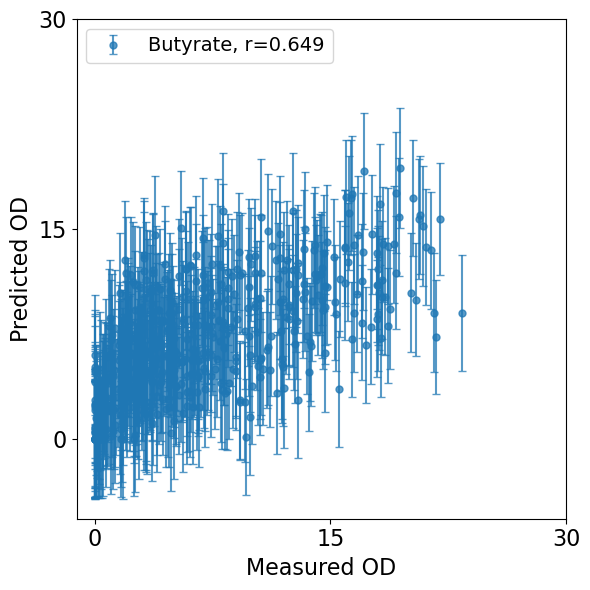

In [9]:
# import kfold results
k_fold_df = pd.read_csv(f"kfold/nofiber/MiRNN_{n_splits}_fold_16h_nofiber.csv")
r_vals = []
mse_vals = []
nll_vals = []

plt.figure(figsize=(6, 6))

for i, obs in enumerate(['Butyrate']):
    true_vals = []
    pred_vals = []
    stdv_vals = []
    
    for exp_name, kf_df in k_fold_df.groupby("Experiments"):
        true_vals_exp = kf_df[f'{obs} true'].values
        pred_vals_exp = kf_df[f'{obs} pred'].values 
        stdv_vals_exp = kf_df[f'{obs} stdv'].values 
        
        # if not nan
        for true_val_exp, pred_val_exp, stdv_val_exp in zip(true_vals_exp[1:], pred_vals_exp[1:], stdv_vals_exp[1:]):
            if not np.isnan(true_val_exp):
                true_vals.append(true_val_exp)
                pred_vals.append(pred_val_exp)
                stdv_vals.append(stdv_val_exp)
    
    true_vals = np.array(true_vals)
    pred_vals = np.array(pred_vals)
    stdv_vals = np.array(stdv_vals)
    
    R = linregress(true_vals, pred_vals).rvalue
    r_vals.append(R)
    mse_vals.append(np.mean((true_vals-pred_vals)**2))
    # nll_vals.append(np.mean((((true_vals-pred_vals)/stdv_vals)**2)/2. + np.log(stdv_vals)))
    plt.errorbar(true_vals, pred_vals, 
                 yerr=stdv_vals, label='{}, r={:.3f}'.format(obs, R),
                 fmt='.', capsize=3, markersize=10, c='C0', alpha=.75)
    
# plot
plt.xticks([0, 15, 30], fontsize=16)
plt.yticks([0, 15, 30], fontsize=16)
plt.xlabel("Measured OD", fontsize=16)
plt.ylabel("Predicted OD", fontsize=16)
plt.legend(loc='upper left', fontsize=14) #, bbox_to_anchor=(1, .5), fontsize=12)
plt.tight_layout()
# plt.savefig(f"figures/improvement/dtl2_butyrate.png")
plt.show()